In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

train_dir = 'fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/Test'

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation = 'softmax')
])

In [5]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [28]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

set_global_policy('float32')

steps_per_epoch = 200
validation_steps = 150

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,  
    steps_per_epoch=steps_per_epoch,  
    validation_steps=validation_steps,  
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/200
200/200 [==============================] - 15s 73ms/step - loss: 0.0763 - accuracy: 0.9900 - val_loss: 0.0343 - val_accuracy: 0.9979 - lr: 1.0000e-06
Epoch 2/200
200/200 [==============================] - 15s 74ms/step - loss: 0.0749 - accuracy: 0.9900 - val_loss: 0.0337 - val_accuracy: 0.9975 - lr: 1.0000e-06
Epoch 3/200
200/200 [==============================] - 14s 72ms/step - loss: 0.0747 - accuracy: 0.9890 - val_loss: 0.0329 - val_accuracy: 0.9992 - lr: 1.0000e-06
Epoch 4/200
200/200 [==============================] - 15s 74ms/step - loss: 0.0752 - accuracy: 0.9875 - val_loss: 0.0381 - val_accuracy: 0.9954 - lr: 1.0000e-06
Epoch 5/200
200/200 [==============================] - 15s 73ms/step - loss: 0.0731 - accuracy: 0.9891 - val_loss: 0.0339 - val_accuracy: 0.9975 - lr: 1.0000e-06
Epoch 6/200
200/200 [==============================] - 15s 75ms/step - loss: 0.0697 - accuracy: 0.9891 - val_loss: 0.0380 - val_accuracy: 0.9962 - lr: 1.0000e-06
Epoch 7/200
200/200 [=======

In [29]:
from tensorflow.keras.optimizers import Adam

num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

for layer in base_model.layers[-5:]:
    layer.trainable = True

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/200
200/200 [==============================] - 17s 79ms/step - loss: 0.0780 - accuracy: 0.9847 - val_loss: 0.0313 - val_accuracy: 0.9967 - lr: 1.0000e-05
Epoch 2/200
200/200 [==============================] - 14s 72ms/step - loss: 0.0811 - accuracy: 0.9869 - val_loss: 0.0321 - val_accuracy: 0.9967 - lr: 1.0000e-05
Epoch 3/200
200/200 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9850
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
200/200 [==============================] - 14s 71ms/step - loss: 0.0819 - accuracy: 0.9850 - val_loss: 0.0409 - val_accuracy: 0.9962 - lr: 1.0000e-05
Epoch 4/200
200/200 [==============================] - 14s 71ms/step - loss: 0.0617 - accuracy: 0.9922 - val_loss: 0.0406 - val_accuracy: 0.9954 - lr: 2.0000e-06
Epoch 5/200
200/200 [==============================] - 15s 73ms/step - loss: 0.0577 - accuracy: 0.9941 - val_loss: 0.0260 - val_accuracy: 0.9975 - lr: 2.0000e-0

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")

50/50 [==============================] - 2s 33ms/step - loss: 0.0192 - accuracy: 1.0000
Test Accuracy: 1.00


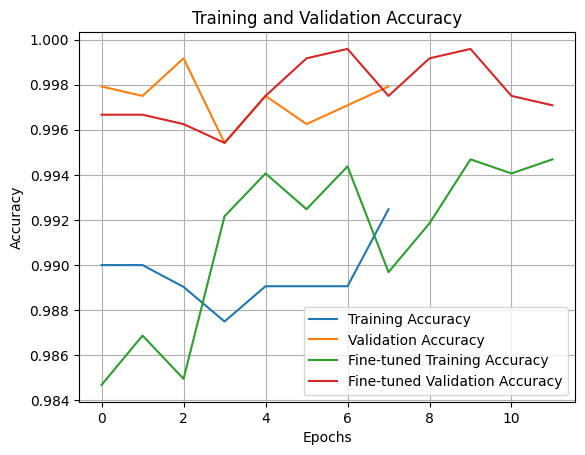

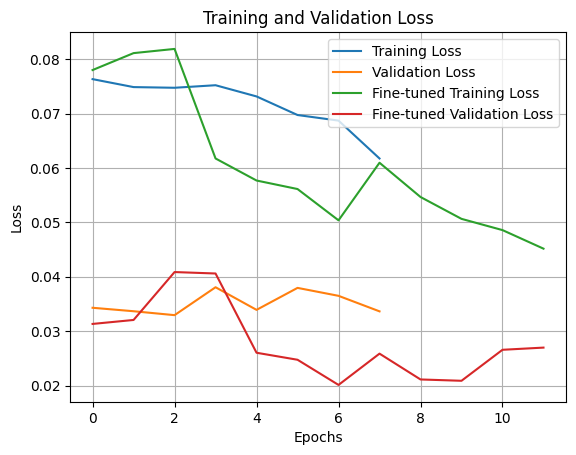

In [31]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 [==============================] - 0s 152ms/step


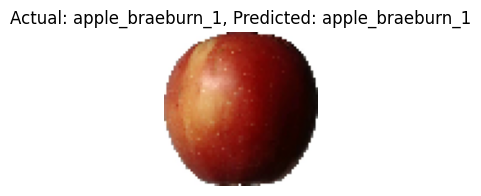

1/1 [==============================] - 0s 22ms/step


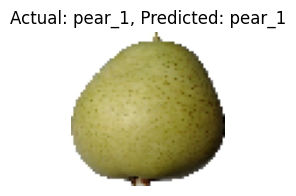

1/1 [==============================] - 0s 22ms/step


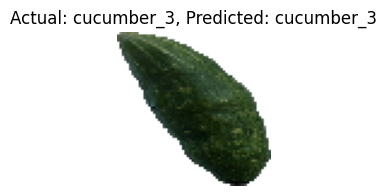

In [32]:
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

actual_count = Counter()
predicted_count = Counter()

def get_class_name_from_index(predicted_index, class_index_mapping):
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown" 

def visualize_prediction_with_actual(img_path, class_index_mapping):
    class_name = os.path.basename(os.path.dirname(img_path))
    
    img = load_img(img_path, target_size=(64, 64)) 
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping) 

sample_images = [
    'fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)


1/1 [==============================] - 2s 2s/step
Prediction: apple_crimson_snow_1


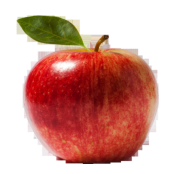

In [38]:
img = load_img('fruit2.png', target_size = (512, 512))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis = 0)
img_array /= 255.0
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction, axis=-1)[0]
predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)
print("Prediction:", predicted_class_name)

plt.figure(figsize=(2, 2), dpi=100)
plt.imshow(img)
plt.axis('off')
plt.show()